# Forecasting Energy Availability from Renewable Sources Using Weather Data

### 1. Aashik Sharif Basheer Ahamed - 011870531
### 2. Sheheryar Ahmad Pirzada - 011869749

In [37]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller  # For performing the Augmented Dickey-Fuller test
from statsmodels.tsa.seasonal import seasonal_decompose  # For decomposing time series data into seasonal components
from statsmodels.tsa.seasonal import STL  # Seasonal-Trend decomposition using LOESS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # For plotting autocorrelation and partial autocorrelation functions
from statsmodels.tsa.statespace.sarimax import SARIMAX  # For seasonal ARIMA models with exogenous variables
from statsmodels.stats.diagnostic import acorr_ljungbox  # For performing Ljung-Box test on residuals
from itertools import product  # Cartesian product for parameter grids
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor  # Machine learning regression models
from statsmodels.tsa.arima.model import ARIMA  # For ARIMA modeling

# Suppress warnings to make output cleaner
import warnings
warnings.filterwarnings("ignore")

In [2]:
path = './data'

# store DataFrames
dataframes = []

# Iterate through each file in the folder
for filename in os.listdir(path):
    if filename.endswith('.csv'):
        # Construct the full path to the CSV file
        file_path = os.path.join(path, filename)

        # Read the CSV file into a DataFrame and append to the list
        frame = pd.read_csv(file_path)
        dataframes.append(frame)
# Concatenate all DataFrames into a single DataFrame
merged_dataframes = pd.concat(dataframes, ignore_index=True)
merged_dataframes

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,seattle,2022-07-01,75.8,57.9,66.3,75.8,57.9,66.3,53.7,64.7,...,28.2,9,10.0,2022-07-01T05:15:51,2022-07-01T21:10:28,0.09,Clear,Clear conditions throughout the day.,clear-day,"72793024233,KSEA,KBFI,72793524234,72793494248,..."
1,seattle,2022-07-02,66.6,56.1,61.1,66.6,56.1,61.1,53.8,77.3,...,19.3,8,10.0,2022-07-02T05:16:29,2022-07-02T21:10:12,0.13,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72793024233,KSEA,KBFI,72793524234,72793494248,..."
2,seattle,2022-07-03,60.2,55.3,56.7,60.2,55.3,56.7,53.2,88.0,...,3.7,1,10.0,2022-07-03T05:17:08,2022-07-03T21:09:53,0.16,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"72793024233,KSEA,KBFI,72793524234,72793494248,..."
3,seattle,2022-07-04,68.8,52.1,60.1,68.8,52.1,60.1,51.0,73.8,...,20.2,9,10.0,2022-07-04T05:17:49,2022-07-04T21:09:31,0.19,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72793024233,KSEA,KBFI,72793524234,72793494248,..."
4,seattle,2022-07-05,73.8,54.7,63.4,73.8,54.7,63.4,53.7,72.6,...,19.5,9,10.0,2022-07-05T05:18:33,2022-07-05T21:09:07,0.23,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"72793024233,KSEA,KBFI,72793524234,72793494248,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5414,seattle,2019-12-27,44.1,36.9,40.8,43.9,32.1,38.5,37.3,87.2,...,1.9,1,NaN,2019-12-27T07:57:01,2019-12-27T16:23:52,0.05,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"F4154,E7103,72793024233,KSEA,KBFI,72793524234,..."
5415,seattle,2019-12-28,47.5,40.9,44.1,45.8,38.7,42.9,39.4,84.0,...,3.8,3,NaN,2019-12-28T07:57:14,2019-12-28T16:24:39,0.08,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"F4154,72793024233,KSEA,KBFI,72793524234,727934..."
5416,seattle,2019-12-29,51.2,41.2,45.3,51.2,40.3,44.5,38.4,77.2,...,4.7,3,NaN,2019-12-29T07:57:25,2019-12-29T16:25:28,0.12,"Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,"72793024233,KSEA,KBFI,72793524234,72793494248,..."
5417,seattle,2019-12-30,48.7,42.6,46.2,45.8,37.8,42.2,40.0,79.5,...,1.0,0,NaN,2019-12-30T07:57:32,2019-12-30T16:26:19,0.15,"Rain, Overcast",Cloudy skies throughout the day with rain clea...,rain,"72793024233,KSEA,KBFI,72793524234,72793494248,..."


In [3]:
# Dataset Information
merged_dataframes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5419 entries, 0 to 5418
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              5419 non-null   object 
 1   datetime          5419 non-null   object 
 2   tempmax           5419 non-null   float64
 3   tempmin           5419 non-null   float64
 4   temp              5419 non-null   float64
 5   feelslikemax      5419 non-null   float64
 6   feelslikemin      5419 non-null   float64
 7   feelslike         5419 non-null   float64
 8   dew               5419 non-null   float64
 9   humidity          5419 non-null   float64
 10  precip            5419 non-null   float64
 11  precipprob        5419 non-null   int64  
 12  precipcover       5419 non-null   float64
 13  preciptype        2840 non-null   object 
 14  snow              5419 non-null   float64
 15  snowdepth         5419 non-null   float64
 16  windgust          4541 non-null   float64


### Data Preprocessing:

In [4]:
# checking null values
merged_dataframes.isnull().sum()

name                   0
datetime               0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
precipcover            0
preciptype          2579
snow                   0
snowdepth              0
windgust             878
windspeed              0
winddir                0
sealevelpressure       0
cloudcover             0
visibility             0
solarradiation         0
solarenergy            0
uvindex                0
severerisk          4392
sunrise                0
sunset                 0
moonphase              0
conditions             0
description            0
icon                   0
stations               0
dtype: int64

In [5]:
# Convert 'datetime' to datetime type with error handling if not already converted
merged_dataframes['datetime'] = pd.to_datetime(merged_dataframes['datetime'], errors='coerce')

# Sort by the 'datetime' column in ascending order
merged_dataframes = merged_dataframes.sort_values(by='datetime', ascending=True).reset_index(drop=True)

# Output the sorted DataFrame
merged_dataframes


,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,seattle,2010-01-01,53.3,45.9,49.3,53.3,41.4,46.6,44.8,84.6,...,1.7,1,NaN,2010-01-01T07:57:39,2010-01-01T16:28:33,0.54,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,rain,"72793024233,KSEA,KBFI,72793524234,72793494248,..."
1,seattle,2010-01-02,49.2,43.3,47.3,45.8,40.3,43.1,43.3,86.0,...,2.1,1,NaN,2010-01-02T07:57:37,2010-01-02T16:29:33,0.57,"Rain, Partially cloudy",Partly cloudy throughout the day with rain cle...,rain,"72793024233,KSEA,KBFI,72793524234,72793494248,..."
2,seattle,2010-01-03,48.8,39.6,44.9,48.8,39.6,44.2,41.3,87.5,...,1.4,1,NaN,2010-01-03T07:57:31,2010-01-03T16:30:34,0.60,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"72793024233,KSEA,KBFI,72793524234,72793494248,..."
3,seattle,2010-01-04,48.3,44.5,46.9,45.8,43.1,44.6,44.6,91.9,...,1.0,1,NaN,2010-01-04T07:57:23,2010-01-04T16:31:37,0.64,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,rain,"72793024233,KSEA,KBFI,72793524234,72793494248,..."
4,seattle,2010-01-05,48.4,45.6,46.9,48.3,42.3,45.1,44.7,92.0,...,0.5,0,NaN,2010-01-05T07:57:12,2010-01-05T16:32:43,0.67,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,rain,"72793024233,KSEA,KBFI,72793524234,72793494248,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5414,seattle,2024-10-28,55.7,49.7,51.9,55.7,45.1,50.7,44.6,76.4,...,4.8,4,10.0,2024-10-28T07:48:22,2024-10-28T17:57:04,0.88,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"72793024233,KSEA,KBFI,72793524234,72793494248,..."
5415,seattle,2024-10-29,55.6,45.9,50.1,55.6,42.8,49.2,43.8,79.8,...,5.7,5,10.0,2024-10-29T07:49:53,2024-10-29T17:55:26,0.91,"Rain, Partially cloudy",Partly cloudy throughout the day with early mo...,rain,"72793024233,KSEA,KBFI,72793524234,72793494248,..."
5416,seattle,2024-10-30,51.8,43.3,46.9,51.8,39.2,44.1,40.8,79.9,...,1.6,1,10.0,2024-10-30T07:51:24,2024-10-30T17:53:50,0.94,"Rain, Partially cloudy",Partly cloudy throughout the day with rain.,rain,"72793024233,KSEA,KBFI,72793524234,72793494248,..."
5417,seattle,2024-10-31,52.0,40.8,46.6,52.0,39.4,45.8,41.9,84.1,...,5.8,3,10.0,2024-10-31T07:52:55,2024-10-31T17:52:16,0.98,"Rain, Overcast",Cloudy skies throughout the day with rain.,rain,"72793024233,KSEA,KBFI,72793524234,72793494248,..."


In [6]:
# check for missing rows
merged_dataframes = merged_dataframes[merged_dataframes.isnull().any(axis=1)]

# count the number of missing rows
num_missing_rows = merged_dataframes.shape[0]

# display the missing rows
print("Missing rows:")
print(merged_dataframes)

# output the number of missing rows
print("Number of missing rows:", num_missing_rows)

Missing rows:
         name   datetime  tempmax  tempmin  temp  feelslikemax  feelslikemin  \
0     seattle 2010-01-01     53.3     45.9  49.3          53.3          41.4   
1     seattle 2010-01-02     49.2     43.3  47.3          45.8          40.3   
2     seattle 2010-01-03     48.8     39.6  44.9          48.8          39.6   
3     seattle 2010-01-04     48.3     44.5  46.9          45.8          43.1   
4     seattle 2010-01-05     48.4     45.6  46.9          48.3          42.3   
...       ...        ...      ...      ...   ...           ...           ...   
5396  seattle 2024-10-10     60.4     50.4  54.4          60.4          50.4   
5397  seattle 2024-10-11     58.8     43.0  52.7          58.8          43.0   
5408  seattle 2024-10-22     57.5     44.6  51.0          57.5          43.2   
5410  seattle 2024-10-24     56.7     45.0  50.0          56.7          43.4   
5411  seattle 2024-10-25     60.0     45.4  52.3          60.0          42.0   

      feelslike   dew  hu

Text(0, 0.5, 'Average temperature (F)')

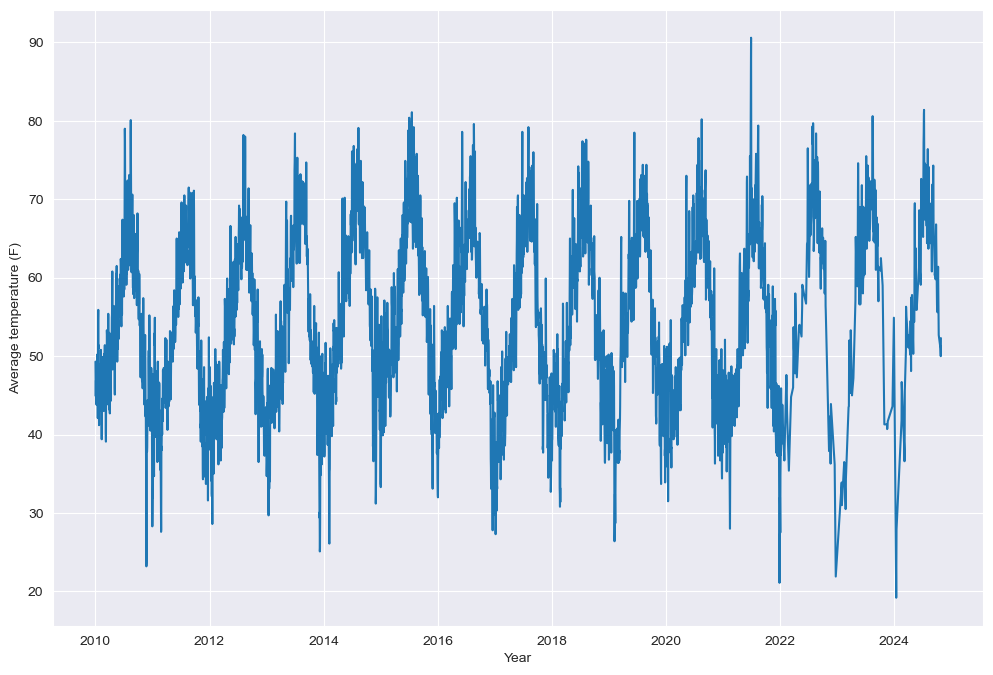

In [7]:
# plot the data for temp
plt.figure(figsize=(12,8))
plt.plot(merged_dataframes['datetime'], merged_dataframes['temp'])
plt.xlabel('Year')
plt.ylabel('Average temperature (F)')

Text(0, 0.5, 'Average Dew')

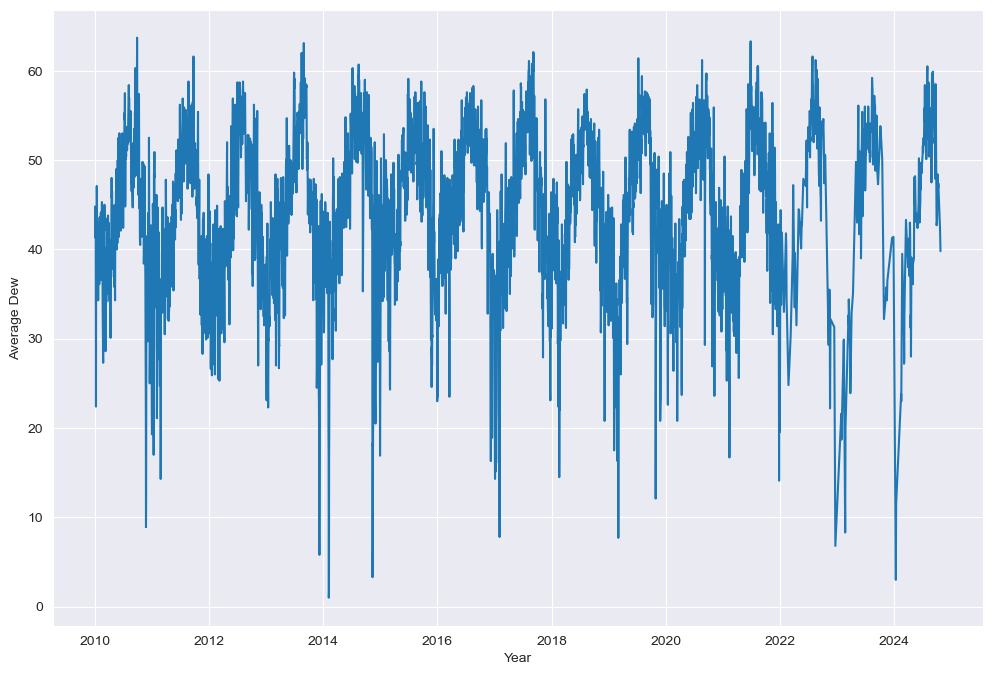

In [8]:
# plot the data for dew
plt.figure(figsize=(12,8))
plt.plot(merged_dataframes['datetime'], merged_dataframes['dew'])
plt.xlabel('Year')
plt.ylabel('Average Dew')

Text(0, 0.5, 'Average Humidity')

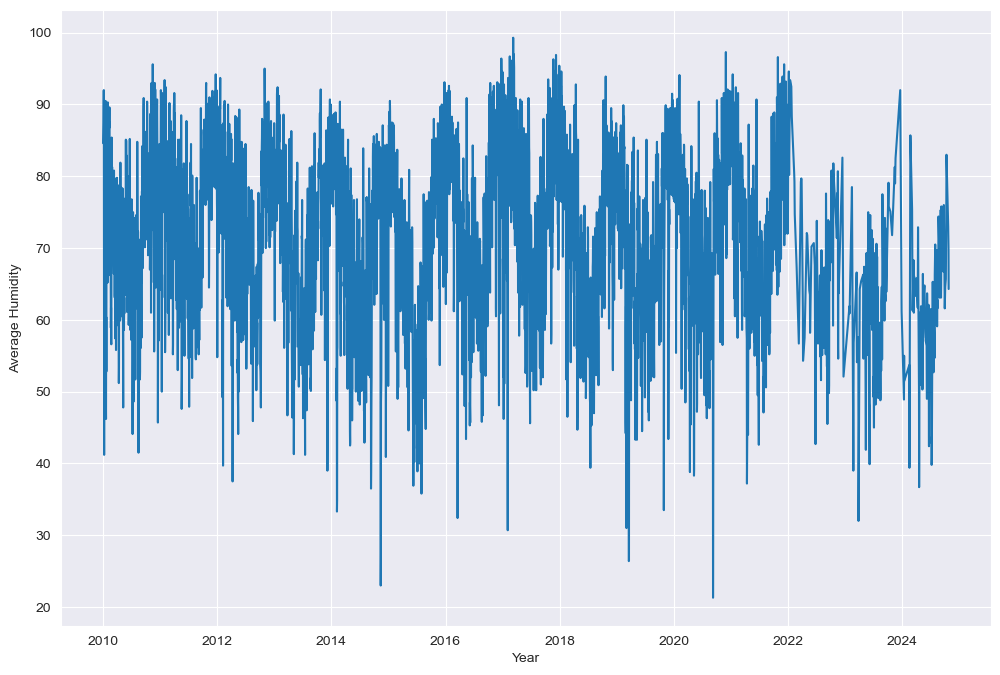

In [9]:
# plot the data for humidity
plt.figure(figsize=(12,8))
plt.plot(merged_dataframes['datetime'], merged_dataframes['humidity'])
plt.xlabel('Year')
plt.ylabel('Average Humidity')

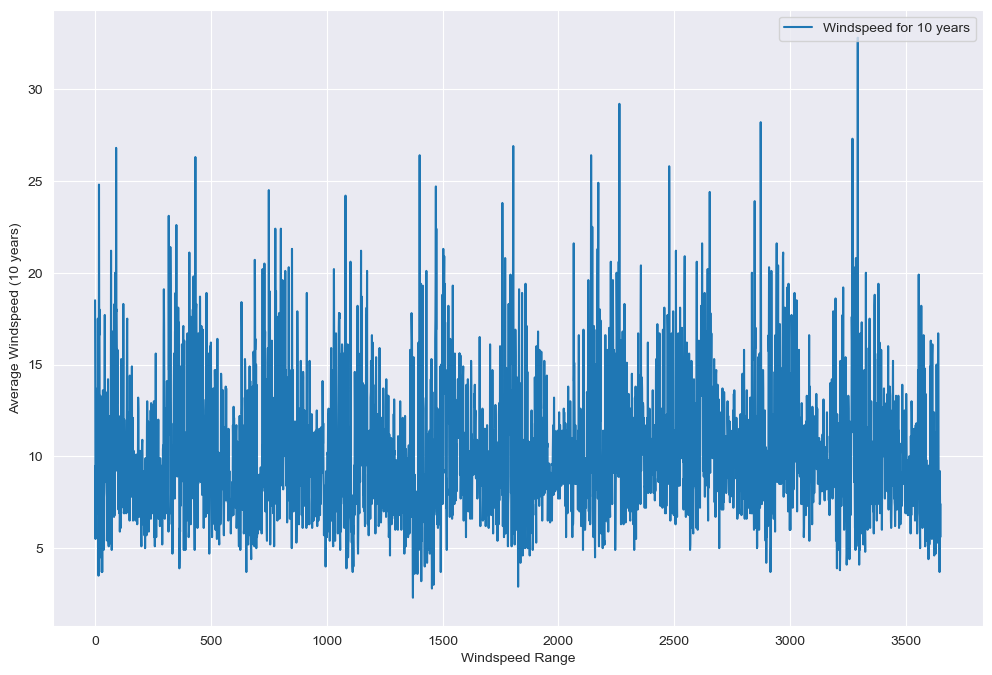

In [10]:
# Look at the first 10 years windspeed
length = 10*365
plt.figure(figsize=(12,8))
plt.plot(range(length), merged_dataframes['windspeed'][:length])
plt.xlabel('Windspeed Range')
plt.ylabel('Average Windspeed (10 years)')
plt.legend(["Windspeed for 10 years"], loc="upper right")

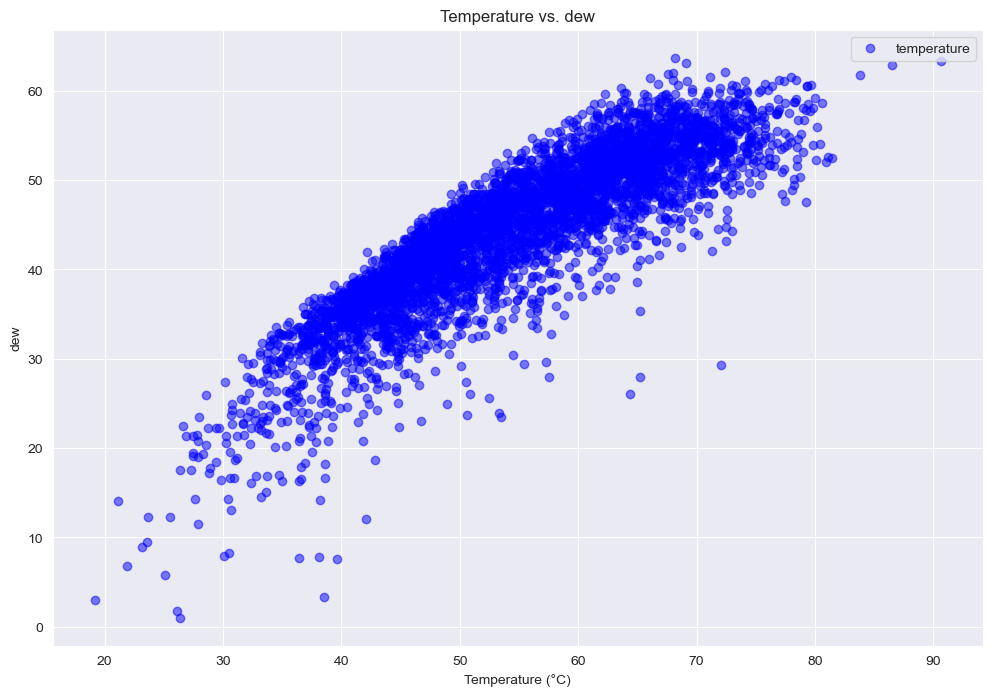

In [11]:
# Scatter plot of temperature vs. dew:
plt.figure(figsize=(12, 8))
plt.scatter(merged_dataframes['temp'], merged_dataframes['dew'], color='blue', alpha=0.5)
plt.title('Temperature vs. dew')
plt.xlabel('Temperature (°C)')
plt.ylabel('dew')
plt.grid(True)
plt.legend(["temperature", "dew"], loc="upper right")
plt.show()

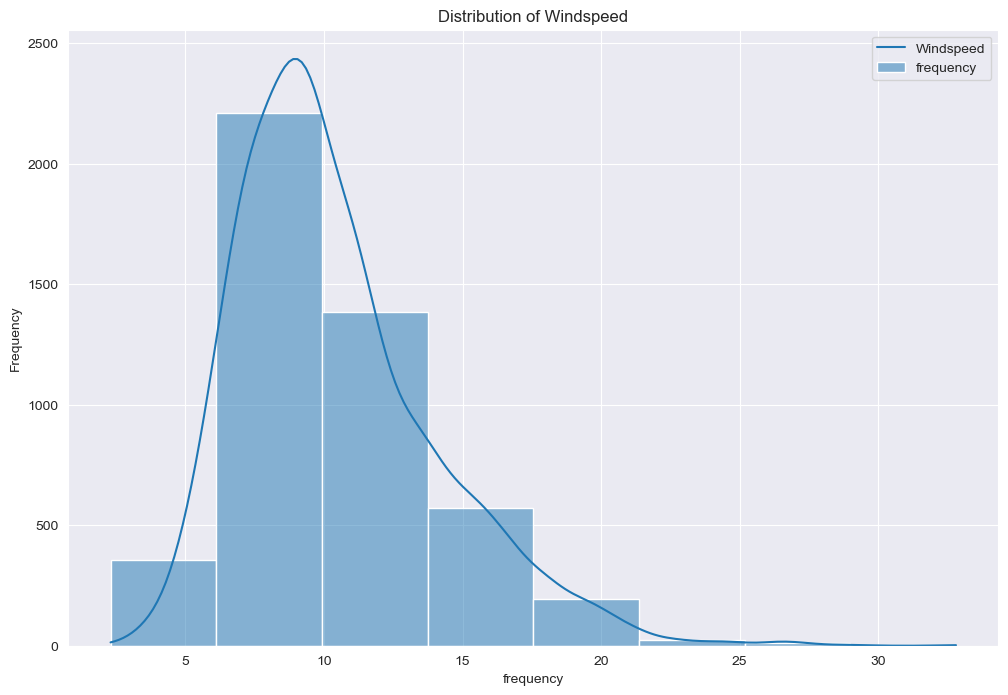

In [12]:
# Histogram of windspeed column
plt.figure(figsize=(12, 8))
sns.histplot(merged_dataframes['windspeed'], bins=8, kde=True)
plt.title('Distribution of Windspeed')
plt.xlabel('frequency')
plt.ylabel('Frequency')
plt.legend(["Windspeed", "frequency"], loc="upper right")
plt.show()

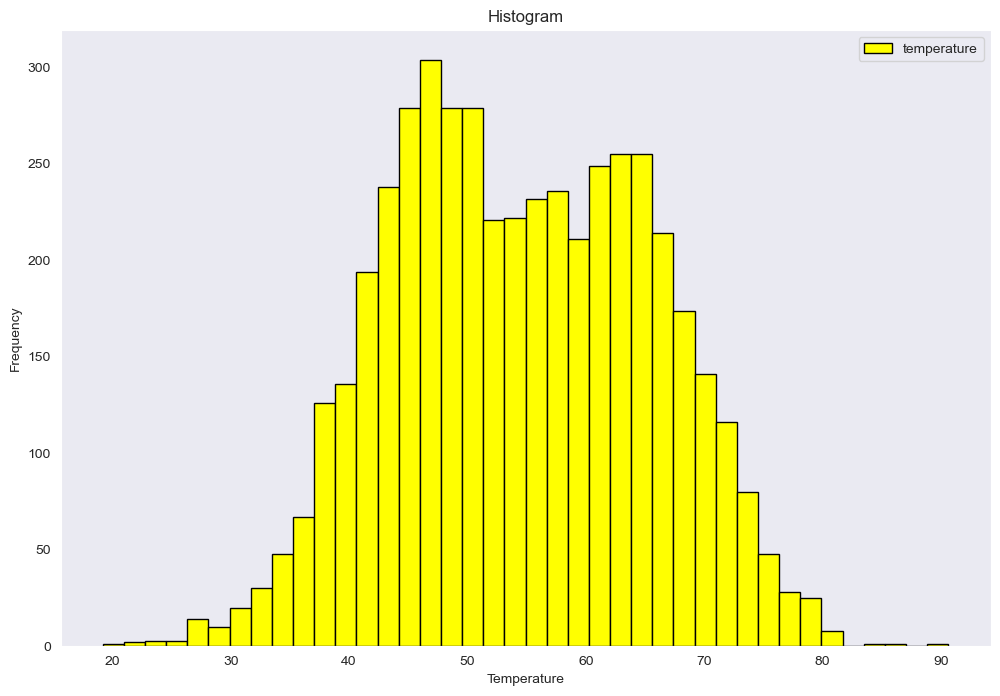

In [13]:
# temperature histogram
plt.figure(figsize=(12, 8))
plt.hist(merged_dataframes['temp'], bins=40, color='yellow', edgecolor='black')
plt.title('Histogram')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(False)
plt.legend(["temperature", "frequency"], loc="upper right")
plt.show()

In [14]:
# columns to fill with 0
columns_to_fill = ['precip', 'snowdepth', 'precipprob', 'preciptype','snow']

# fill missing values with 0 for specified columns
merged_dataframes[columns_to_fill] = merged_dataframes[columns_to_fill].fillna(0)

In [15]:
# convert integer values in the 'preciptype' column to strings
merged_dataframes['preciptype'] = merged_dataframes['preciptype'].astype(str)

# fill missing values in the 'preciptype' column with a specified string value
missing_value = 'no precipitation'
merged_dataframes['preciptype'].fillna(missing_value, inplace=True)

In [16]:
# define a function to convert 'preciptype' column
def fill_preciptype(value):
    if value != 0:
        return 1
    else:
        return value
# Fill the 'preciptype' column with 1 where the value is not 0
merged_dataframes['preciptype'] = merged_dataframes['preciptype'].apply(lambda x: fill_preciptype(x))

In [17]:
merged_dataframes.isnull().sum()

name                   0
datetime               0
tempmax                0
tempmin                0
temp                   0
feelslikemax           0
feelslikemin           0
feelslike              0
dew                    0
humidity               0
precip                 0
precipprob             0
precipcover            0
preciptype             0
snow                   0
snowdepth              0
windgust             878
windspeed              0
winddir                0
sealevelpressure       0
cloudcover             0
visibility             0
solarradiation         0
solarenergy            0
uvindex                0
severerisk          4392
sunrise                0
sunset                 0
moonphase              0
conditions             0
description            0
icon                   0
stations               0
dtype: int64

In [18]:
merged_dataframes

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,seattle,2010-01-01,53.3,45.9,49.3,53.3,41.4,46.6,44.8,84.6,...,1.7,1,NaN,2010-01-01T07:57:39,2010-01-01T16:28:33,0.54,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,rain,"72793024233,KSEA,KBFI,72793524234,72793494248,..."
1,seattle,2010-01-02,49.2,43.3,47.3,45.8,40.3,43.1,43.3,86.0,...,2.1,1,NaN,2010-01-02T07:57:37,2010-01-02T16:29:33,0.57,"Rain, Partially cloudy",Partly cloudy throughout the day with rain cle...,rain,"72793024233,KSEA,KBFI,72793524234,72793494248,..."
2,seattle,2010-01-03,48.8,39.6,44.9,48.8,39.6,44.2,41.3,87.5,...,1.4,1,NaN,2010-01-03T07:57:31,2010-01-03T16:30:34,0.60,"Rain, Partially cloudy",Partly cloudy throughout the day with late aft...,rain,"72793024233,KSEA,KBFI,72793524234,72793494248,..."
3,seattle,2010-01-04,48.3,44.5,46.9,45.8,43.1,44.6,44.6,91.9,...,1.0,1,NaN,2010-01-04T07:57:23,2010-01-04T16:31:37,0.64,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,rain,"72793024233,KSEA,KBFI,72793524234,72793494248,..."
4,seattle,2010-01-05,48.4,45.6,46.9,48.3,42.3,45.1,44.7,92.0,...,0.5,0,NaN,2010-01-05T07:57:12,2010-01-05T16:32:43,0.67,"Rain, Overcast",Cloudy skies throughout the day with a chance ...,rain,"72793024233,KSEA,KBFI,72793524234,72793494248,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5396,seattle,2024-10-10,60.4,50.4,54.4,60.4,50.4,54.4,46.9,76.0,...,9.1,6,10.0,2024-10-10T07:21:56,2024-10-10T18:29:35,0.25,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72793024233,KSEA,KBFI,72793524234,72793494248,..."
5397,seattle,2024-10-11,58.8,43.0,52.7,58.8,43.0,52.5,47.4,83.0,...,6.3,4,10.0,2024-10-11T07:23:21,2024-10-11T18:27:39,0.31,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72793024233,KSEA,KBFI,72793524234,72793494248,..."
5408,seattle,2024-10-22,57.5,44.6,51.0,57.5,43.2,49.9,42.3,73.0,...,11.8,7,10.0,2024-10-22T07:39:23,2024-10-22T18:07:16,0.68,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72793024233,KSEA,KBFI,72793524234,72793494248,..."
5410,seattle,2024-10-24,56.7,45.0,50.0,56.7,43.4,48.9,40.2,69.9,...,9.4,6,10.0,2024-10-24T07:42:22,2024-10-24T18:03:47,0.75,Partially cloudy,Partly cloudy throughout the day.,partly-cloudy-day,"72793024233,KSEA,KBFI,72793524234,72793494248,..."


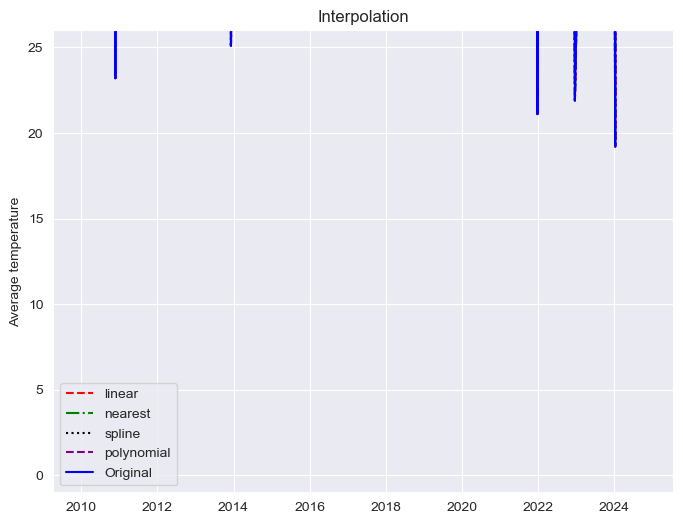

In [25]:
# Perform different interpolation methods and store the results in new columns
# Linear interpolation
merged_dataframes['linear_interp'] = merged_dataframes['temp'].interpolate(method='linear')

# Nearest interpolation
merged_dataframes['nearest_interp'] = merged_dataframes['temp'].interpolate(method='nearest')

# Spline interpolation
merged_dataframes['spline_interp'] = merged_dataframes['temp'].interpolate(method='spline', order=2)

# Polynomial interpolation
merged_dataframes['polynomial_interp'] = merged_dataframes['temp'].interpolate(method='polynomial', order=3)

# Plot
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the interpolated data
plt.plot(merged_dataframes['datetime'], merged_dataframes['linear_interp'], linestyle='--', color='red', label='linear')
plt.plot(merged_dataframes['datetime'], merged_dataframes['nearest_interp'], linestyle='-.', color='green', label='nearest')
plt.plot(merged_dataframes['datetime'], merged_dataframes['spline_interp'], linestyle=':', color='black', label='spline')
plt.plot(merged_dataframes['datetime'], merged_dataframes['polynomial_interp'], linestyle='--', color='purple', label='polynomial')

# Plot the original data
plt.plot(merged_dataframes['datetime'], merged_dataframes['temp'], label='Original', color='blue')

# Add legend and labels
plt.legend()
plt.ylabel('Average temperature')
plt.ylim(-1, 26)
plt.title('Interpolation')

# Show plot
plt.show()

In [26]:
# Let's say we want to create extra columns: month, year, and week of the year
merged_dataframes['month'] = merged_dataframes['datetime'].dt.month
merged_dataframes['year'] = merged_dataframes['datetime'].dt.year
merged_dataframes['week_of_year'] = merged_dataframes['datetime'].dt.isocalendar().week
merged_dataframes

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,description,icon,stations,linear_interp,nearest_interp,spline_interp,polynomial_interp,month,year,week_of_year
0,seattle,2010-01-01,53.3,45.9,49.3,53.3,41.4,46.6,44.8,84.6,...,Cloudy skies throughout the day with a chance ...,rain,"72793024233,KSEA,KBFI,72793524234,72793494248,...",49.3,49.3,49.3,49.3,1,2010,53
1,seattle,2010-01-02,49.2,43.3,47.3,45.8,40.3,43.1,43.3,86.0,...,Partly cloudy throughout the day with rain cle...,rain,"72793024233,KSEA,KBFI,72793524234,72793494248,...",47.3,47.3,47.3,47.3,1,2010,53
2,seattle,2010-01-03,48.8,39.6,44.9,48.8,39.6,44.2,41.3,87.5,...,Partly cloudy throughout the day with late aft...,rain,"72793024233,KSEA,KBFI,72793524234,72793494248,...",44.9,44.9,44.9,44.9,1,2010,53
3,seattle,2010-01-04,48.3,44.5,46.9,45.8,43.1,44.6,44.6,91.9,...,Cloudy skies throughout the day with a chance ...,rain,"72793024233,KSEA,KBFI,72793524234,72793494248,...",46.9,46.9,46.9,46.9,1,2010,1
4,seattle,2010-01-05,48.4,45.6,46.9,48.3,42.3,45.1,44.7,92.0,...,Cloudy skies throughout the day with a chance ...,rain,"72793024233,KSEA,KBFI,72793524234,72793494248,...",46.9,46.9,46.9,46.9,1,2010,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5396,seattle,2024-10-10,60.4,50.4,54.4,60.4,50.4,54.4,46.9,76.0,...,Partly cloudy throughout the day.,partly-cloudy-day,"72793024233,KSEA,KBFI,72793524234,72793494248,...",54.4,54.4,54.4,54.4,10,2024,41
5397,seattle,2024-10-11,58.8,43.0,52.7,58.8,43.0,52.5,47.4,83.0,...,Partly cloudy throughout the day.,partly-cloudy-day,"72793024233,KSEA,KBFI,72793524234,72793494248,...",52.7,52.7,52.7,52.7,10,2024,41
5408,seattle,2024-10-22,57.5,44.6,51.0,57.5,43.2,49.9,42.3,73.0,...,Partly cloudy throughout the day.,partly-cloudy-day,"72793024233,KSEA,KBFI,72793524234,72793494248,...",51.0,51.0,51.0,51.0,10,2024,43
5410,seattle,2024-10-24,56.7,45.0,50.0,56.7,43.4,48.9,40.2,69.9,...,Partly cloudy throughout the day.,partly-cloudy-day,"72793024233,KSEA,KBFI,72793524234,72793494248,...",50.0,50.0,50.0,50.0,10,2024,43


In [27]:
merged_dataframes.isnull().sum()

name                    0
datetime                0
tempmax                 0
tempmin                 0
temp                    0
feelslikemax            0
feelslikemin            0
feelslike               0
dew                     0
humidity                0
precip                  0
precipprob              0
precipcover             0
preciptype              0
snow                    0
snowdepth               0
windgust              878
windspeed               0
winddir                 0
sealevelpressure        0
cloudcover              0
visibility              0
solarradiation          0
solarenergy             0
uvindex                 0
severerisk           4392
sunrise                 0
sunset                  0
moonphase               0
conditions              0
description             0
icon                    0
stations                0
linear_interp           0
nearest_interp          0
spline_interp           0
polynomial_interp       0
month                   0
year        

In [28]:
# Set the 'datetime' column as the index
merged_dataframes.set_index('datetime', inplace=True)

In [29]:
# Forward fill missing values
merged_df_filled_ffill = merged_dataframes.fillna(method='ffill')

# Backward fill missing values
merged_df_filled_bfill = merged_dataframes.fillna(method='bfill')

# Output the DataFrames with missing values filled using forward fill and backward fill
print(merged_df_filled_ffill)
print(merged_df_filled_bfill)

               name  tempmax  tempmin  temp  feelslikemax  feelslikemin  \
datetime                                                                  
2010-01-01  seattle     53.3     45.9  49.3          53.3          41.4   
2010-01-02  seattle     49.2     43.3  47.3          45.8          40.3   
2010-01-03  seattle     48.8     39.6  44.9          48.8          39.6   
2010-01-04  seattle     48.3     44.5  46.9          45.8          43.1   
2010-01-05  seattle     48.4     45.6  46.9          48.3          42.3   
...             ...      ...      ...   ...           ...           ...   
2024-10-10  seattle     60.4     50.4  54.4          60.4          50.4   
2024-10-11  seattle     58.8     43.0  52.7          58.8          43.0   
2024-10-22  seattle     57.5     44.6  51.0          57.5          43.2   
2024-10-24  seattle     56.7     45.0  50.0          56.7          43.4   
2024-10-25  seattle     60.0     45.4  52.3          60.0          42.0   

            feelslike   

In [30]:
merged_dataframes = merged_dataframes.ffill()  # forward fill
merged_dataframes = merged_dataframes.bfill()  ## backward fill
merged_dataframes.isnull().sum()

name                 0
tempmax              0
tempmin              0
temp                 0
feelslikemax         0
feelslikemin         0
feelslike            0
dew                  0
humidity             0
precip               0
precipprob           0
precipcover          0
preciptype           0
snow                 0
snowdepth            0
windgust             0
windspeed            0
winddir              0
sealevelpressure     0
cloudcover           0
visibility           0
solarradiation       0
solarenergy          0
uvindex              0
severerisk           0
sunrise              0
sunset               0
moonphase            0
conditions           0
description          0
icon                 0
stations             0
linear_interp        0
nearest_interp       0
spline_interp        0
polynomial_interp    0
month                0
year                 0
week_of_year         0
dtype: int64

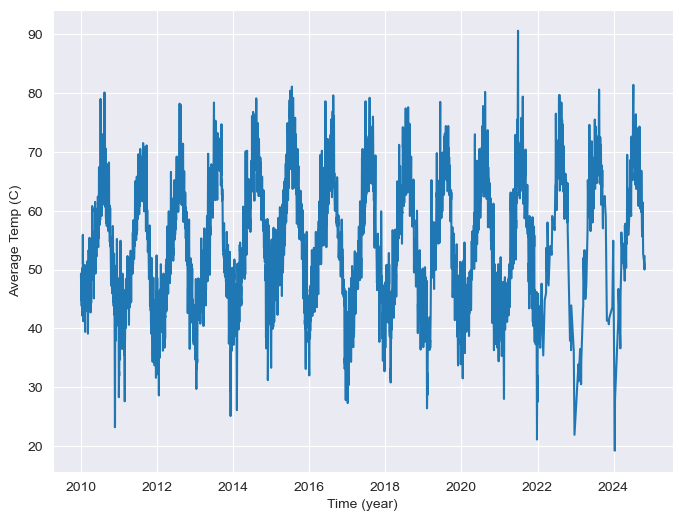

In [31]:
# plot full time series again
plt.figure(figsize=(8,6))
plt.plot(merged_dataframes.index, merged_dataframes['temp'])
plt.ylabel('Average Temp (C)')
_=plt.xlabel('Time (year)')

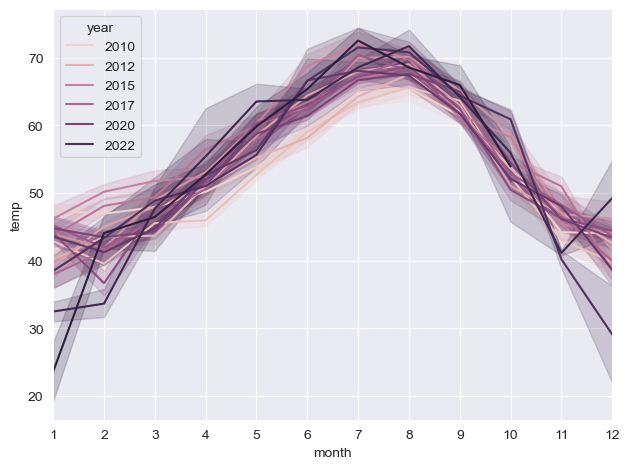

In [32]:
# visualize trends across years
sns.lineplot(x='month', y='temp', data=merged_dataframes, hue='year')
plt.xticks(np.arange(1, 13), rotation=0)  # Set x-ticks labels as months
plt.xlim(1, 12)  # Limit x-axis to months 1 to 12
plt.tight_layout()
plt.show()

In [33]:
# time series decomposition
data = merged_dataframes['temp'].resample('M').mean().ffill().to_frame()  # one value per month
data

,temp
datetime,
2010-01-31,47.380645
2010-02-28,46.932143
2010-03-31,47.909677
2010-04-30,50.183333
2010-05-31,53.812903
...,...
2024-06-30,65.381818
2024-07-31,72.565217
2024-08-31,68.580952


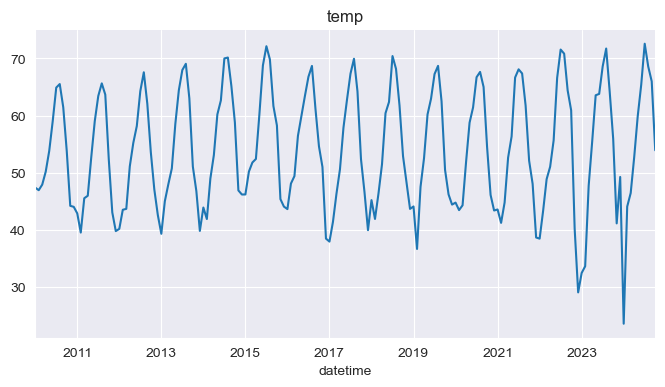

In [34]:
# time series plot
data['temp'].plot(kind='line', figsize=(8, 4), title='temp')
plt.gca().spines[['top', 'right']].set_visible(False)

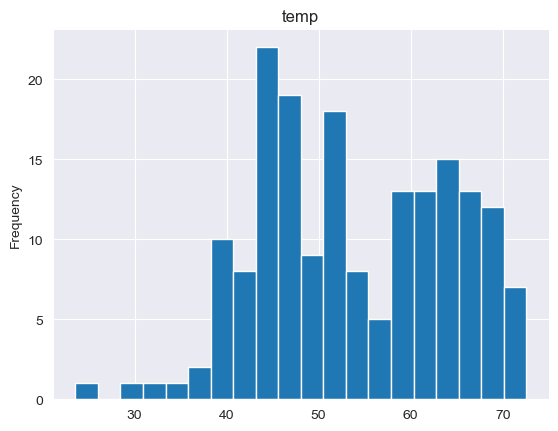

In [35]:
# bar plot
data['temp'].plot(kind='hist', bins=20, title='temp')
plt.gca().spines[['top', 'right',]].set_visible(False)

## SEASONAL DECOMPOSITION

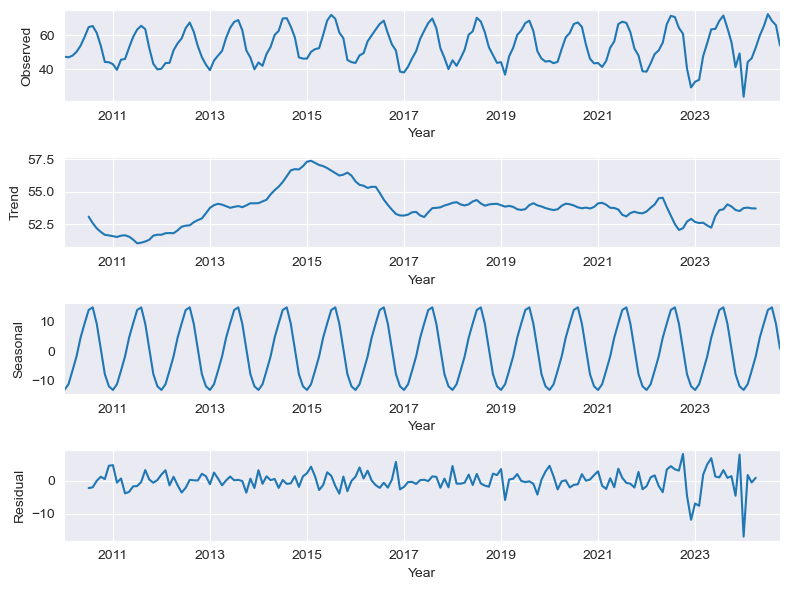

In [39]:
# Perform seasonal decomposition
decomposition = seasonal_decompose(data['temp'], model='additive')

# Plot the decomposition
fig, axes = plt.subplots(4, 1, figsize=(8, 6))
decomposition.observed.plot(ax=axes[0], legend=False)
axes[0].set_ylabel('Observed')
axes[0].set_xlabel('Year')
decomposition.trend.plot(ax=axes[1], legend=False)
axes[1].set_ylabel('Trend')
axes[1].set_xlabel('Year')
decomposition.seasonal.plot(ax=axes[2], legend=False)
axes[2].set_ylabel('Seasonal')
axes[2].set_xlabel('Year')
decomposition.resid.plot(ax=axes[3], legend=False)
axes[3].set_ylabel('Residual')
axes[3].set_xlabel('Year')

# Add grid to the seasonal plot
axes[2].grid()

# Adjust layout
plt.tight_layout()
plt.show()

## CHECKING STATIONARY OF THE DATA

In [40]:
# Perform ADF test
adf_result = adfuller(data['temp'])

print('ADF Statistic: %.2f' % adf_result[0])
print('ADF p-value: %.4f' % adf_result[1])

ADF Statistic: -2.15
ADF p-value: 0.2262


## AUTOCORRELATION AND PARTIAL AUTO-CORRELATION

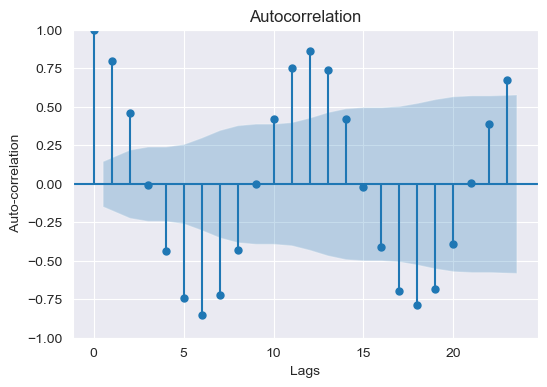

In [41]:
# Calculate auto-correlation using Pandas
fig, ax = plt.subplots(figsize=(6,4))
_=plot_acf(data['temp'], ax=ax)
_=plt.xlabel('Lags')
_=plt.ylabel(' Auto-correlation')

The shaded area represent the upper and lower bounds for critical values where null hypothesis cannon be rejected and it can be said that null hypothesis can be rejected only for lag = 1.

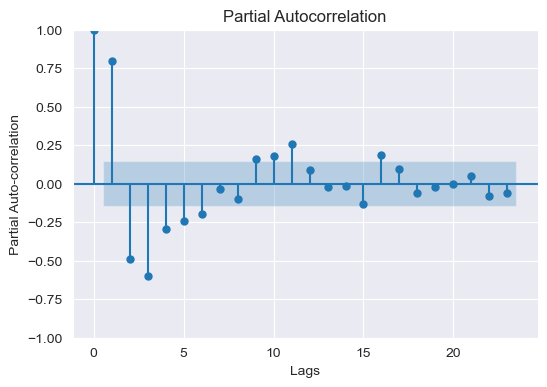

In [42]:
# Partial auto-correlation
fig, ax = plt.subplots(figsize=(6,4))
_=plot_pacf(data['temp'], ax=ax)
_=plt.xlabel('Lags')
_=plt.ylabel('Partial Auto-correlation')

From the graph it can be said that at lag = 1 the auto correlation is significant and the shaded area represent the upper and lower bound s for critical value where null hypothesis cannot be rejected

## SPLITTING DATA

In [43]:
# Split the dataset
train = data[:'2022']  # all data until 2022
validation = data.loc['2023'] # all data for 2023
test = data.loc['2024']  # all data for 2024
print('Start and end of training set:\t\t', train.index.min(), train.index.max())
print('Start and end of validation set:\t', validation.index.min(), validation.index.max())
print('Start and end of test set:\t\t', test.index.min(), test.index.max())

Start and end of training set:		 2010-01-31 00:00:00 2022-12-31 00:00:00
Start and end of validation set:	 2023-01-31 00:00:00 2023-12-31 00:00:00
Start and end of test set:		 2024-01-31 00:00:00 2024-10-31 00:00:00


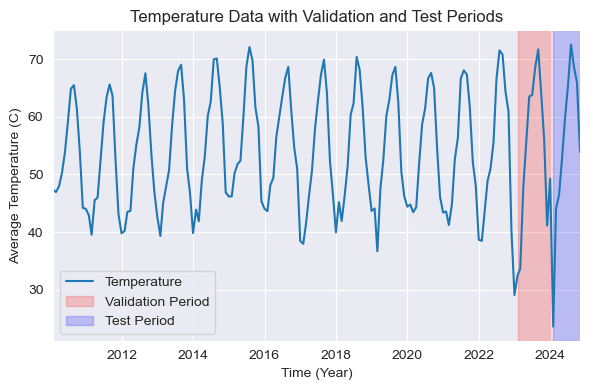

In [44]:
# Plotting the dataset
plt.figure(figsize=(6, 4))
plt.plot(data.index, data['temp'], label='Temperature')

# Highlighting the validation and test periods
plt.axvspan(validation.index.min(), validation.index.max(), alpha=0.2, color='red', label='Validation Period')
plt.axvspan(test.index.min(), test.index.max(), alpha=0.2, color='blue', label='Test Period')

# Adding labels and title
plt.xlabel('Time (Year)')
plt.ylabel('Average Temperature (C)')
plt.xlim(train.index.min(), test.index.max())
plt.title('Temperature Data with Validation and Test Periods')

# Adding legend and grid
plt.legend()
plt.grid(True)

# Displaying the plot
plt.tight_layout()
plt.show()

The temperature data with validation and test periods is plotted in the graph. The validation period lies in the range of 2019 to 2020 where temperature has reached maximum of 17 degree centigrade and test data is from 2020 to rest.

## PARAMETER EVALUATION

In [45]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score


def measure_forecast_error(label, forecast):
    mae = mean_absolute_error(label, forecast)
    mape = mean_absolute_percentage_error(label, forecast)
    mse = mean_squared_error(label, forecast)
    rmse = np.sqrt(mse)
    r2 = r2_score(label, forecast)

    print('MAE = %.2f (degrees Celsius)' % mae)
    print('MAPE = %.2f %%' % (100 * mape))
    print('RMSE = %.2f (degrees Celsius)' % rmse)
    print('MSE = %.2f (degrees Celsius squared)' % mse)
    print('R2 = %.2f' % r2)

MAE = 10.95 (degrees Celsius)
MAPE = 23.27 %
RMSE = 12.69 (degrees Celsius)
MSE = 160.95 (degrees Celsius squared)
R2 = -0.00


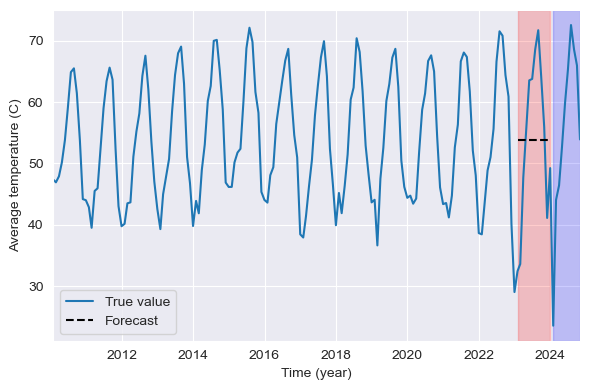

In [46]:
# Calculate baseline mean
baseline = train['temp'].mean()

# Apply baseline mean to validation set
validation['baseline'] = baseline

# Measure error for validation set
measure_forecast_error(validation['temp'], validation['baseline'])

# Plotting
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(data.index, data['temp'], label='True value')
ax.plot(validation.index, validation['baseline'], '--', color='k', label='Forecast')
ax.axvspan(validation.index.min(), validation.index.max(), alpha=.2, color='red')  # validation set
ax.axvspan(test.index.min(), test.index.max(), alpha=.2, color='blue')  # test set
ax.set_xlabel('Time (year)')
ax.set_ylabel('Average temperature (C)')
ax.set_xlim(train.index.min(), test.index.max())
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [47]:
train.loc['2021']['temp']

datetime
2021-01-31    43.558065
2021-02-28    41.214286
2021-03-31    44.770968
2021-04-30    52.630000
2021-05-31    56.335484
2021-06-30    66.650000
2021-07-31    68.083871
2021-08-31    67.361290
2021-09-30    61.733333
2021-10-31    52.100000
2021-11-30    48.043333
2021-12-31    38.654839
Freq: ME, Name: temp, dtype: float64

MAE = 11.02 (degrees Celsius)
MAPE = 23.21 %
RMSE = 12.70 (degrees Celsius)
MSE = 161.20 (degrees Celsius squared)
R2 = -0.00


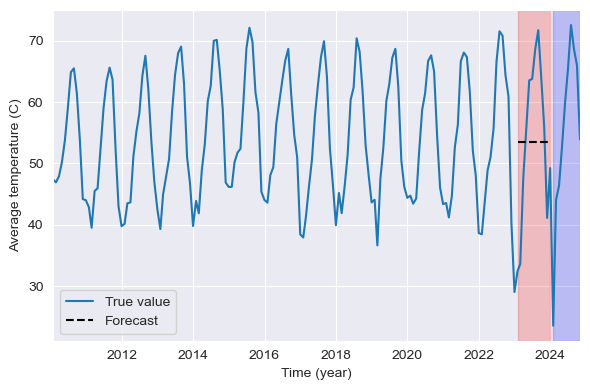

In [48]:
# Calculate baseline forecast using the last period in 2021
baseline_period = train.loc['2021', 'temp'].mean()

# Apply baseline forecast to the validation set
validation['baseline_period'] = baseline_period

# Measure error for validation set
measure_forecast_error(validation['temp'], validation['baseline_period'])

# Plotting
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(data.index, data['temp'], label='True value')
ax.plot(validation.index, validation['baseline_period'], '--', color='k', label='Forecast')
ax.axvspan(validation.index.min(), validation.index.max(), alpha=.2, color='red')  # validation set
ax.axvspan(test.index.min(), test.index.max(), alpha=.2, color='blue')  # test set
ax.set_xlabel('Time (year)')
ax.set_ylabel('Average temperature (C)')
ax.set_xlim(train.index.min(), test.index.max())
plt.legend(loc='best')
plt.tight_layout()
plt.show()

ADF Statistic: -5.93
ADF p-value: 0.000


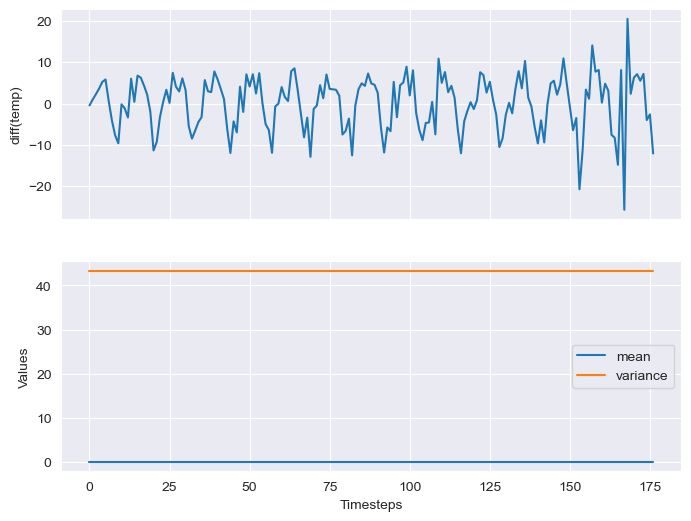

In [49]:
# Compute differences
diff_temp = np.diff(data['temp'].values, n=1)

# Compute mean and variance over time
mean_diff = np.mean(diff_temp)
var_diff = np.var(diff_temp)

# Plotting
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
ax[0].plot(diff_temp)
ax[1].plot(np.arange(len(diff_temp)), mean_diff * np.ones_like(diff_temp), label='mean')
ax[0].set_ylabel('diff(temp)')
ax[1].plot(np.arange(len(diff_temp)), var_diff * np.ones_like(diff_temp), label='variance')
ax[1].legend(loc='best')
ax[1].set_xlabel('Timesteps')
ax[1].set_ylabel('Values')

# Augmented Dickey-Fuller test
adf_result_diff = adfuller(diff_temp, maxlag=30)
print('ADF Statistic: %.2f' % adf_result_diff[0])
print('ADF p-value: %.3f' % adf_result_diff[1])

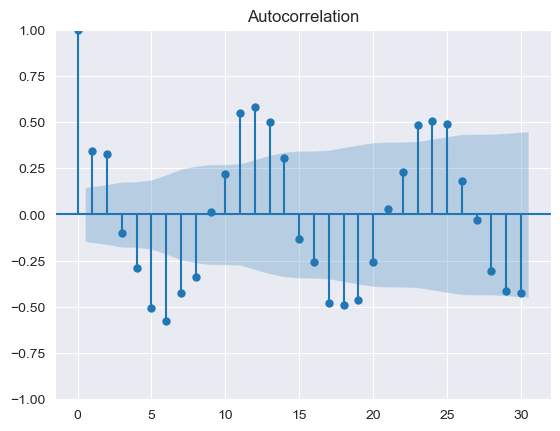

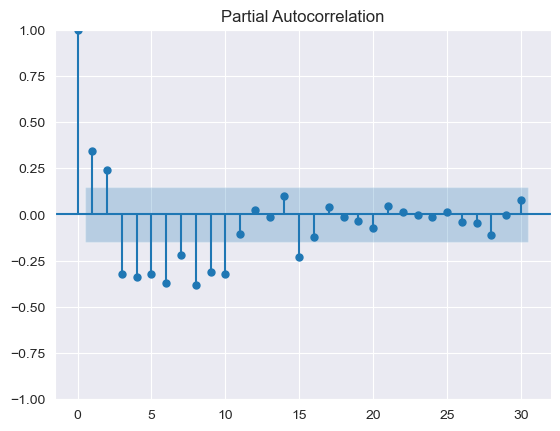

In [50]:
_=plot_acf(diff_temp, lags=30)
_=plot_pacf(diff_temp, lags=30)

The shaded area represent the upper and lower bounds for critical values where null hypothesis cannon be rejected and it can be said that null hypothesis can be rejected only for lag = 1.

From the graph it can be said that at lag = 1 the auto correlation is significant and the shaded area represent the upper and lower bound s for critical value where null hypothesis cannot be rejected

In [51]:
def optimize_arma_model(timeseries, orders):
    """
    Function to find the best ARMA model order based on the Akaike Information Criterion (AIC).

    Args:
        timeseries (pd.Series): The time series data for which the ARMA model needs to be fitted.
        orders (list of tuples): A list of (p, q) tuples representing the order combinations to be tested.

    Returns:
        pd.DataFrame: A DataFrame sorted by the AIC values in ascending order.
    """

    # Initialize an empty list to store (p, q) order and corresponding AIC values
    results = []

    # Iterate over each (p, q) combination from the provided list
    for p, q in orders:
        try:
            # Fit the ARMA model with the current (p, q) order
            model = ARMA(timeseries, order=(p, q)).fit(disp=False)
            # Append the model's (p, q) order and AIC to the results list
            results.append([(p, q), model.aic])
        except:
            # Continue to the next combination if the current model fails to fit
            continue

    # Convert the results list into a DataFrame
    result = pd.DataFrame(results, columns=['(p, q)', 'AIC'])

    # Return the DataFrame sorted by AIC in ascending order
    return result.sort_values(by='AIC', ascending=True)


In [52]:
from statsmodels.tsa.arima_model import ARMA


def optimize_arma_model(timeseries, orders):
    results = []
    for p, q in orders:
        try:
            model = ARMA(timeseries, order=(p, q)).fit(disp=False)
        except:
            continue
        results.append([(p, q), model.aic])
    result = pd.DataFrame(results, columns=['(p, q)', 'AIC'])
    result.sort_values(by='AIC', ascending=True, inplace=True)  # Sort the DataFrame by AIC
    return result

## Model Building

In [53]:
# Select the target variable (e.g., snow, snowdepth, etc.)
target_variable = 'temp'

# Define the order of the ARMA model
p = 2  # Autoregressive (AR) order
q = 1  # Moving Average (MA) order

# Create and fit the ARMA model
model = ARIMA(data[target_variable], order=(p, 0, q))
results = model.fit()

# Print the summary of the ARMA model
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                   temp   No. Observations:                  178
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -510.925
Date:                Wed, 20 Nov 2024   AIC                           1031.851
Time:                        01:23:00   BIC                           1047.759
Sample:                    01-31-2010   HQIC                          1038.302
                         - 10-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         53.7964      0.345    155.952      0.000      53.120      54.472
ar.L1          1.6534      0.035     46.855      0.000       1.584       1.723
ar.L2         -0.9083      0.031    -28.956      0.0

## MACHINE LEARNING FOR TIME SERIES FORECASTING

In [54]:
# Define the window size and forecast horizon
window_size = 14
forecast_horizon = 3

# Create lagged features using rolling window
temp_avg_df = data['temp'].copy().to_frame()
for lag in range(1, window_size + 1):
    temp_avg_df[f'temp_avg_lag{lag}'] = temp_avg_df['temp'].shift(lag)

# Shift the target variable to represent the forecast horizon
temp_avg_df['y'] = temp_avg_df['temp'].shift(-forecast_horizon)

# Drop rows with NaN values in the target variable
temp_avg_df.dropna(subset=['y'], inplace=True)

In [55]:
temp_avg_df.dropna(inplace=True)
temp_avg_df

,temp,temp_avg_lag1,temp_avg_lag2,temp_avg_lag3,temp_avg_lag4,temp_avg_lag5,temp_avg_lag6,temp_avg_lag7,temp_avg_lag8,temp_avg_lag9,temp_avg_lag10,temp_avg_lag11,temp_avg_lag12,temp_avg_lag13,temp_avg_lag14,y
datetime,,,,,,,,,,,,,,,,
2011-03-31,45.529032,39.521429,42.874194,44.019355,44.196667,53.796774,61.446667,65.506452,64.887097,59.050000,53.812903,50.183333,47.909677,46.932143,47.380645,59.023333
2011-04-30,45.956667,45.529032,39.521429,42.874194,44.019355,44.196667,53.796774,61.446667,65.506452,64.887097,59.050000,53.812903,50.183333,47.909677,46.932143,63.419355
2011-05-31,52.722581,45.956667,45.529032,39.521429,42.874194,44.019355,44.196667,53.796774,61.446667,65.506452,64.887097,59.050000,53.812903,50.183333,47.909677,65.625806
2011-06-30,59.023333,52.722581,45.956667,45.529032,39.521429,42.874194,44.019355,44.196667,53.796774,61.446667,65.506452,64.887097,59.050000,53.812903,50.183333,63.660000
2011-07-31,63.419355,59.023333,52.722581,45.956667,45.529032,39.521429,42.874194,44.019355,44.196667,53.796774,61.446667,65.506452,64.887097,59.050000,53.812903,52.335484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-31,46.437500,44.066667,23.566667,49.250000,41.125000,55.925000,64.193750,71.722222,68.592593,63.786364,63.543750,55.420000,47.700000,33.620000,32.450000,65.381818
2024-04-30,52.727273,46.437500,44.066667,23.566667,49.250000,41.125000,55.925000,64.193750,71.722222,68.592593,63.786364,63.543750,55.420000,47.700000,33.620000,72.565217
2024-05-31,59.853846,52.727273,46.437500,44.066667,23.566667,49.250000,41.125000,55.925000,64.193750,71.722222,68.592593,63.786364,63.543750,55.420000,47.700000,68.580952


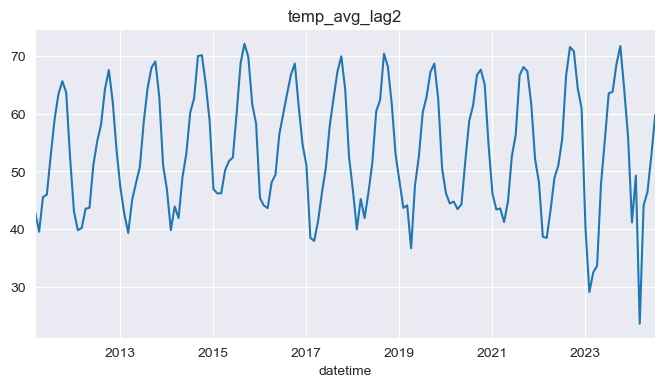

In [56]:
# time series plot
temp_avg_df['temp_avg_lag2'].plot(kind='line', figsize=(8, 4), title='temp_avg_lag2')
plt.gca().spines[['top', 'right']].set_visible(False)

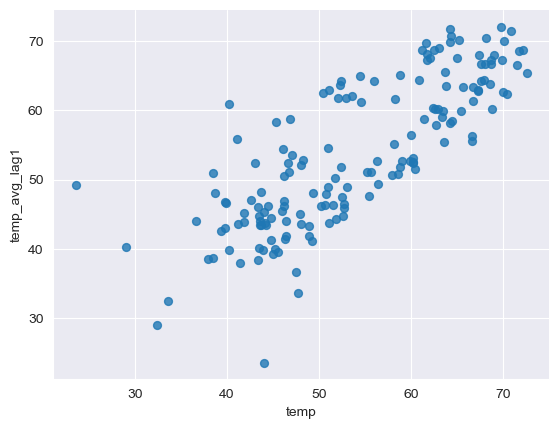

In [57]:
# scatter plot
temp_avg_df.plot(kind='scatter', x='temp', y='temp_avg_lag1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [58]:
# Split into training, validation, and test sets:
features = list(temp_avg_df.columns)[:-1]
temp_tr = temp_avg_df[:'2022']
temp_val = temp_avg_df.loc['2023']
temp_test = temp_avg_df.loc['2024']

In [59]:
# Define models list
models = [
    ('Random Forest', RandomForestRegressor()),
    ('Gradient Boosting', GradientBoostingRegressor())
]

# Fit models and print forecast errors
for mname, model in models:
    model.fit(temp_tr[features], temp_tr['y'])
    temp_val['y_pred_%s' % mname] = model.predict(temp_val[features])
    print(mname)
    measure_forecast_error(temp_val['y'], temp_val['y_pred_%s' % mname])

Random Forest
MAE = 3.97 (degrees Celsius)
MAPE = 10.16 %
RMSE = 5.55 (degrees Celsius)
MSE = 30.75 (degrees Celsius squared)
R2 = 0.82
Gradient Boosting
MAE = 4.69 (degrees Celsius)
MAPE = 11.79 %
RMSE = 6.31 (degrees Celsius)
MSE = 39.87 (degrees Celsius squared)
R2 = 0.77


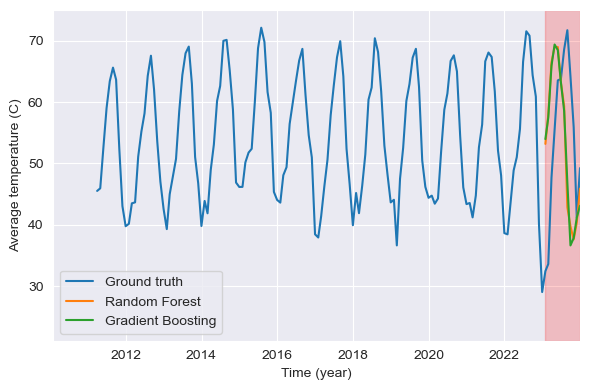

In [61]:
# Set the baseline prediction using the last period in the training set
validation['baseline_last_period'] = train.loc['2022']['temp'].values

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(6,4))

# Plot the ground truth temperature
ax.plot(temp_avg_df.index, temp_avg_df['temp'], label='Ground truth')

# Iterate over each model and plot its predictions
for mname, model in models:
    # Predict the temperature using the current model
    y_pred = model.predict(temp_val[features])
    # Plot the predicted temperature
    ax.plot(temp_val.index, y_pred, label=mname)

# Highlight the validation set
ax.axvspan(temp_val.index.min(), validation.index.max(), alpha=.2, color='red')  # validation set

# Set labels for the axes
ax.set_xlabel('Time (year)')
ax.set_ylabel('Average temperature (C)')

# Set the x-axis limit to show data from the training set to the end of the validation set
ax.set_xlim(train.index.min(), validation.index.max())

# Add a legend to the plot
plt.legend(loc='best')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()